In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import scipy.interpolate as interp
import h5py
from tqdm import tqdm
import math as math

import matplotlib.pyplot as plt
from time import sleep

In [2]:
def diff(p, dim):
    if dim==0:
        p_xdiff = p[1:,:,:] - p[:-1,:,:]
        return torch.cat((p_xdiff, p_xdiff[-2:-1,:,:]))
    elif dim==1:
        p_ydiff = p[:,1:,:] - p[:,:-1,:]
        return torch.cat((p_ydiff, p_ydiff[:,-2:-1,:]), dim=1)
    else:
        raise ValueError('Diff dimension should by either 0 or 1.')



def interpolate2d(coords, values, targets):
    ####### Format of inputs is inconsistent
    Nx, Ny, Ndim = coords.shape
    Mx, My, Mdim = targets.shape
    
    # Reshape input coordinates & values, and truncate edges
    A  = coords[:-1, :-1, :].view(1, 1, Nx-1, Ny-1, Ndim)
    B  = coords[ 1:, :-1, :].view(1, 1, Nx-1, Ny-1, Ndim)
    C  = coords[:-1,  1:, :].view(1, 1, Nx-1, Ny-1, Ndim)
    D  = coords[ 1:,  1:, :].view(1, 1, Nx-1, Ny-1, Ndim)
    
    VA = values[:-1, :-1   ].view(1, 1, Nx-1, Ny-1)
    VB = values[ 1:, :-1   ].view(1, 1, Nx-1, Ny-1)
    VC = values[:-1,  1:   ].view(1, 1, Nx-1, Ny-1)
    VD = values[ 1:,  1:   ].view(1, 1, Nx-1, Ny-1)

    
    # Reshape target coordinates
    Tx = targets[:,:,0].view(Mx, My, 1, 1)
    Ty = targets[:,:,1].view(Mx, My, 1, 1)
    
    # Compute difference vectors
    AB = B - A
    AC = C - A
    DB = B - D
    DC = C - D
    
    # Seperate x- and y-variables for brevity
    Ax  =  A[:, :, :, :, 0]
    Ay  =  A[:, :, :, :, 1]
    Dx  =  D[:, :, :, :, 0]
    Dy  =  D[:, :, :, :, 1]
    
    ABx =  AB[:, :, :, :, 0]
    ABy =  AB[:, :, :, :, 1]
    ACx =  AC[:, :, :, :, 0]
    ACy =  AC[:, :, :, :, 1]
    DBx =  DB[:, :, :, :, 0]
    DBy =  DB[:, :, :, :, 1]
    DCx =  DC[:, :, :, :, 0]
    DCy =  DC[:, :, :, :, 1]

    
    # Compute coefficients
    denom_A = ABx*ACy - ABy*ACx
    b_A = ((Tx - Ax)*ACy + (Ay-Ty)*ACx) / denom_A
    c_A = ((Ax - Tx)*ABy  + (Ty-Ay)*ABx)  / denom_A
    
    denom_D = DBx*DCy - DBy*DCx
    b_D = ((Tx - Dx)*DCy + (Dy-Ty)*DCx) / denom_D
    c_D = ((Dx - Tx)*DBy  + (Ty-Dy)*DBx)  / denom_D
    
    # Mask coefficients to limit to corresponding triangles
    # Note: Each triangle ABC or DBC only corresponds with a small number of
    # target samples that lie inside that triangle. The rest of the target
    # samples is ignored by that triangle through masking. Furthermore,
    # in order to correctly count the edges, the A- and D-masks are slightly
    # different: A uses ≥ & ≤, while D uses >. Lastly, bc_A is used both for
    # the A- and D-masks, to prevent rounding errors causing excluding or
    # counting points in both masks. Some rounding errors can still occur
    # for two nearby A- or D-triangles, though these should be virtually
    # nonexistent in practice.
    bc_A = b_A+c_A
    bc_D = b_D+c_D   ######
    mask_A = torch.logical_and(torch.logical_and(b_A>=0, c_A>=0), bc_A<=1)
    mask_D = torch.logical_and(torch.logical_and(b_D>0, c_D>0), bc_D<1)
    
    # Compute interpolated values
    interp_values = torch.sum(mask_A * (VA + (VB-VA)*b_A + (VC-VA)*c_A), (2,3))\
                  + torch.sum(mask_D * (VD + (VB-VD)*b_D + (VC-VD)*c_D), (2,3))
    
    return interp_values

In [3]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print('Running on CUDA')
else:
    dev = torch.device("cpu")
    print('Running on CPU')

    
# Define vector space functions
def grid_vector3(v):
    """Create 3D (NxMx3) vector array."""
    return torch.tensor(v, dtype=torch.float32, device=dev).view(1,1,3) ####### NxM

def grid_scalar(s):
    """Create (NxMx1) scalar array."""
    return torch.tensor(s, dtype=torch.float32, device=dev).view(1,1,1) ####### NxM

def ttensor(t):
    """Shortcut for torch.tensor() with dtype=torch.float32 and device=dev."""
    return torch.tensor(t, dtype=torch.float32, device=dev)

def zeros(shape):
    """Create """ ##### create vector and scalar versions
    return torch.zeros(shape, dtype=torch.float32, device=dev)

def ones(shape):  ##### create vector and scalar versions
    return torch.ones(shape, dtype=torch.float32, device=dev)

def inner(v, w):
    """Vector inner product for NxMxD vector arrays, where D is vector dimension."""
    return torch.sum(v*w, dim=2, keepdim=True)

def norm(v):
    """L2-norm for NxMxD vector arrays, where D is vector dimension."""
    return torch.norm(v, dim=2, keepdim=True)

def normsq(v):
    """L2-norm squared for NxMxD vector arrays, where D is vector dimension."""
    return inner(v,v)

def unit(v):
    """Unit vectors for NxMxD vector arrays, where D is vector dimension."""
    return v / norm(v)

    
def projection(v, w):
    """Vector projections of vector v onto vector w for NxMx3 tensors."""
    wunit = unit(w)
    return inner(v, wunit) * wunit


def rejection(v, w):
    """Vector rejections of vector v onto vector w for NxMx3 tensors."""
    return v - projection(v, w)


# Define ray operations
def dist_to_plane(ray_pos, ray_dir, plane_pos, plane_dir):
    """Scalar distance along ray to plane."""
    return inner((plane_pos - ray_pos), (plane_dir)) / inner(ray_dir, plane_dir)
    
def ray_plane_intersect(ray_pos, ray_dir, plane_pos, plane_dir):
    """Vector point of ray intersection with plane."""
    t = dist_to_plane(ray_pos, ray_dir, plane_pos, plane_dir)
    return ray_pos + ray_dir*t
    
    
#### Implement directional vector / pos-dir classes, representing rays, or infinite planes; ray.dir, ray.pos, plane.dir, plane.pos
    
def thinlens(ray_pos, ray_dir, lens_pos, lens_dir, f):
    """New ray position, direction and additional path length for thin lens."""
    L   = lens_pos
    BFP = L - f*lens_dir                                       # Back focal plane center
    FFP = L + f*lens_dir                                       # Front focal plane center
    P   = ray_plane_intersect(ray_pos, ray_dir, L, lens_dir)   # Ray intersection with lens plane
    Q   = ray_plane_intersect(L, ray_dir, BFP, lens_dir)       # Ray intersection with back focal plane
    new_ray_dir = unit(Q-P)                                    # New ray direction
    
    A = ray_plane_intersect(ray_pos, ray_dir, FFP, lens_dir)   # Ray intersection with front focal plane
    K = ray_plane_intersect(P, new_ray_dir, BFP, new_ray_dir)  # Ray intersection with isophase plane at BFP
    Delta = 2*f - norm(A-P) - norm(P-K)
#     Delta = f - torch.sqrt(f*f + normsq(P-L))
    return P, new_ray_dir, Delta


def pathlength(points, ns, extra):
    """Path length.""" ##### description
    Nx, Ny, Ndim = points[0].shape
    pathlength = extra * ones((Nx, Ny, 1))
    for i in range(len(points)-1):
        pathlength += norm(points[i+1] - points[i]) * ns[i]
    return pathlength

    
def snellsvec(k_in, N, n_in=1, n_out=1):
    """
    Compute direction vectors of refracted ray for NxMx3 tensors.

    Input:
    k_in    Directional unit vector incoming ray
    N       Surface normal unit vector
    n_in    Refractive index incoming ray
    n_out   Refractive index outgoing ray

    Output:
    k_out   Directional unit vector outgoing ray
    """
    k_inrej = rejection(-k_in, N)       # Perpendicular component k_in
    k_outrej = -n_in/n_out * k_inrej    # Perpendicular component k_out
    k_out = k_outrej - N * torch.sqrt(1 - inner(k_outrej, k_outrej))

    return k_out


def propagate2surf3D(A, k, Csphere, Rsphere, Rring):
    """
    Propagate light ray along z-axis to surface perpendicular to z.

    Input:
    A       Starting position of ray. (x,y,z).
    k       Directional unit vector of ray. (kx, ky, kz). Must have nonzero
            z-component.
    z       Position of surface on z axis. (scalar).
    Rsphere Radius of spherical surface. If Rsphere=0, a flat surface will be
            used. (scalar).
    Rring   Radius indicating the size of the lens. Rays outside this radius
            shall not pass! (scalar).

    Output:
    B       Arrival position of ray at surface. (x,y,z)
    N       Surface normal unit vector. (Nx, Ny, Nz).
    """
#     zdist = z - A                   # Compute relative distance to front

    if Rsphere == 0:                # Flat surface
#         B = A + k * zdist/k[:,:,2]  # Scale k to flat surface
#         N = torch.tensor((0, 0, -1)).view(1,1,3) # Surface normal of flat surface
        pass

    else:                           # Spherical surface
        # See: https://en.wikipedia.org/wiki/Line%E2%80%93sphere_intersection
        # Compute intermediate terms
#         Csphere = torch.tensor((0, 0, z)).view(1,1,3)  # Sphere center
        ACsphere = A - Csphere                          # Center relative to A
        kinACsphere = inner(k, ACsphere)                # Inner product k,ACsph

        # Compute solutions to line-sphere intersection
        discriminant = torch.sqrt(kinACsphere*kinACsphere - inner(ACsphere, ACsphere)
                               + Rsphere*Rsphere)       # Discriminant of ABC equation
        kdist1 = -kinACsphere + discriminant
        kdist2 = -kinACsphere - discriminant
        #####
#         ksort = torch.sort((kdist1, kdist2))

#         if discriminant <= 0:                           # No solutions
#             print('Warning: rays out of bounds!')
#             return

        # Solutions must be forward
        
#         if ksort[0] > 0:
#             kdist = ksort[0]
#         elif ksort[1] > 0:
#             kdist = ksort[1]
#         else:
#             print('Warning: no intersection found in forward ray direction!')
        
#         kmask_less = (kdist1 < kdist2)
#         kmask1 = torch.logical_and(kdist1>0, kmask_less)
#         kmask2 = torch.logical_and(kdist2>0, torch.logical_not(kmask_less))
#         kdist = kdist1*kmask1 + kdist2*kmask2

        eps = 10 * torch.finfo(torch.float32).eps       ##### Machine epsilon for float32, pick larger value due to multiple operations
        k_1eps = (kdist1 > eps)
        k_2eps = (kdist2 > eps)
        k_1l2  = (kdist1 < kdist2)
        
        kmask1 = torch.logical_and(k_1eps, torch.logical_or(torch.logical_not(k_2eps), k_1l2))
        kmask2 = torch.logical_and(k_2eps, torch.logical_or(torch.logical_not(k_1eps), torch.logical_not(k_1l2)))
        kdist  = kdist1*kmask1 + kdist2*kmask2
    
        #####
#         plt.imshow(kdist.detach().squeeze())
#         plt.title('kdist')
#         plt.colorbar()
#         plt.show()
        #####
        
        B = A + k * kdist                               # Solution for intersec
        N = unit(B - Csphere) * torch.sign(torch.tensor(Rsphere))     # Compute normal vector

    return B, N

Running on CUDA


In [4]:
def half_diameter(f, NA, n):
    """
    Compute the diameter/2
    from focal distance f, Numerical Aperture NA, and refractive index n.
    Note: not a torch tensor function."""
    NAn = NA/n
    return f * NAn / np.sqrt(1-NAn*NAn)

In [5]:
def RayTransfer(A, B, C, D, p_in, k_in):
    ##### Note! This only works for meridional rays (no tangential component)
    
    ##### tan(theta) instead of sin(theta) !
    pr_in = torch.sqrt(p_in[:,:,0]*p_in[:,:,0] + p_in[:,:,1]*p_in[:,:,1])
    kr_in = torch.sqrt(k_in[:,:,0]*k_in[:,:,0] + k_in[:,:,1]*k_in[:,:,1]) / k_in[:,:,2]
    pr_out = A*pr_in + B*kr_in
    kr_out = (C*pr_in + D*kr_in)
    
    ##### Be wary of divide by 0 errors! Rewrite?
    px_out = p_in[:,:,0] * pr_out / pr_in
    py_out = p_in[:,:,1] * pr_out / pr_in
    kx_out = k_in[:,:,0] * kr_out / kr_in
    ky_out = k_in[:,:,1] * kr_out / kr_in
    
    ##### Add z distance
    p_out = torch.stack((px_out, py_out, p_in[:,:,2]), 2)
    k_out = torch.stack((kx_out, ky_out, k_in[:,:,2]), 2)
    
    return p_out, k_out

In [6]:
p_in = torch.tensor((2,1,0), dtype=torch.float32).view(1,1,3)
k_in = torch.tensor((2,1,0.5), dtype=torch.float32).view(1,1,3)

RayTransfer(1,0,0,1, p_in, k_in)

(tensor([[[2., 1., 0.]]]), tensor([[[2.0000, 1.0000, 0.5000]]]))

In [7]:
def plotrays(points, dimhori=2, dimvert=1):
    """Plot lines between given NxMx3 points in 3D on a 2D plot."""
    
    # Prepare variables
    dimlabels = ['x', 'y', 'z']
    points_hori = torch.stack(points)[:,:,:,dimhori].view(len(points), -1).detach().cpu()
    points_vert = torch.stack(points)[:,:,:,dimvert].view(len(points), -1).detach().cpu()
    
    # Plot figure
    fig = plt.figure(figsize=(7,7))
    fig.dpi = 80
    plt.plot(points_hori, points_vert, '.-')
    plt.gca().axis('equal')
    plt.xlabel(dimlabels[dimhori])
    plt.ylabel(dimlabels[dimvert])
    plt.title('Ray Paths')
    plt.show()

In [8]:
def plotresult(interp_values_attached, stuff_attached):
    interp_values = interp_values_attached.detach().cpu()
    values_attached, pscreen_attached, targets_attached, Nx, Ny, Nx_screen, Ny_screen = stuff_attached
    values = values_attached.detach().cpu()
    pscreen = pscreen_attached.detach().cpu()
    targets = targets_attached.detach().cpu()

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
    fig.dpi = 80
    xc = pscreen.view(Nx*Ny, 3)[:, 0]
    yc = pscreen.view(Nx*Ny, 3)[:, 1]
    xt = targets.view(Nx_screen*Ny_screen, 2)[:, 0]
    yt = targets.view(Nx_screen*Ny_screen, 2)[:, 1]
    scat = ax1.scatter(xc, yc, s=8, c=values, label='Rays')#, vmin=0)
    plt.colorbar(scat, ax=ax1)
    ax1.plot(xt, yt, '.w', markersize=0.8, label='Output image')
    ax1.axis('equal')
    ax1.set_facecolor('black')
    legend = ax1.legend(loc=2, facecolor='#444444')
    for text in legend.get_texts():
        text.set_color("white")
    ax1.set_title('Ray positions and values on screen')

    plt.imshow(interp_values.T)#, vmin=0)
    plt.gca().invert_yaxis()
    plt.colorbar(ax=ax2)
    ax2.set_title('Output image (normalized)')

    plt.show()

In [9]:
# Test for snellsvec
kx = torch.tensor(((0,0),(0,0)), dtype=torch.float32)
ky = torch.tensor(((0,0),(1,1)), dtype=torch.float32)
kz = torch.tensor(((1,1),(1,1)), dtype=torch.float32)
k  = unit(torch.stack((kx,ky,kz), 2))

Nx = torch.tensor(((0,0), (0,0)), dtype=torch.float32)
Ny = torch.tensor(((0,-1),(0,-1)), dtype=torch.float32)
Nz = torch.tensor(((-1,-1),(-1,-1)), dtype=torch.float32)
N  = unit(torch.stack((Nx,Ny,Nz), 2))

n1 = 1
n2 = 1.5

k_out = snellsvec(k, N, n1, n2)
k_out

tensor([[[0.0000, 0.0000, 1.0000],
         [0.0000, 0.2903, 0.9569]],

        [[0.0000, 0.4714, 0.8819],
         [0.0000, 0.7071, 0.7071]]])

In [10]:
import numpy as np
theta1=np.pi/4
print(f'{np.arcsin(n1/n2 * np.sin(theta1))}')
print(np.pi/4 - np.arctan(k_out[0,1,1]/k_out[0,1,2]).item())
print(np.arctan(k_out[1,0,1]/k_out[1,0,2]).item())

0.4908826782893113
0.4908827026678493
0.49088266491889954


In [11]:
help(propagate2surf3D)

Help on function propagate2surf3D in module __main__:

propagate2surf3D(A, k, Csphere, Rsphere, Rring)
    Propagate light ray along z-axis to surface perpendicular to z.
    
    Input:
    A       Starting position of ray. (x,y,z).
    k       Directional unit vector of ray. (kx, ky, kz). Must have nonzero
            z-component.
    z       Position of surface on z axis. (scalar).
    Rsphere Radius of spherical surface. If Rsphere=0, a flat surface will be
            used. (scalar).
    Rring   Radius indicating the size of the lens. Rays outside this radius
            shall not pass! (scalar).
    
    Output:
    B       Arrival position of ray at surface. (x,y,z)
    N       Surface normal unit vector. (Nx, Ny, Nz).



In [12]:
help(snellsvec)

Help on function snellsvec in module __main__:

snellsvec(k_in, N, n_in=1, n_out=1)
    Compute direction vectors of refracted ray for NxMx3 tensors.
    
    Input:
    k_in    Directional unit vector incoming ray
    N       Surface normal unit vector
    n_in    Refractive index incoming ray
    n_out   Refractive index outgoing ray
    
    Output:
    k_out   Directional unit vector outgoing ray



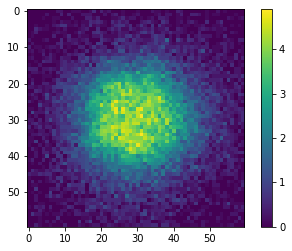

edge to center: 9.50µm


In [13]:
# Load target image
mat = {}
with h5py.File('/home/daniel/NTFS-HDD/ScientificData/raylearn-data/frame-led.mat', 'r') as file:
    for k, v in file.items():
        mat[k] = np.array(v)
    
frame_cropped = ttensor(mat['frame_cropped'])
frame_cropped_normalized = frame_cropped / torch.mean(frame_cropped, (0,1))

colrange_um = mat['colrange_um']
rowrange_um = mat['rowrange_um']
measure_offset_um = mat['measure_offset_um']
xymax_mm = float(mat['xymax_um'] * 1e-3);

plt.imshow(frame_cropped_normalized.cpu())
plt.colorbar()
plt.show()

print(f'edge to center: {1e3*xymax_mm:.2f}µm')

Initial guess: d = 0.0600mm


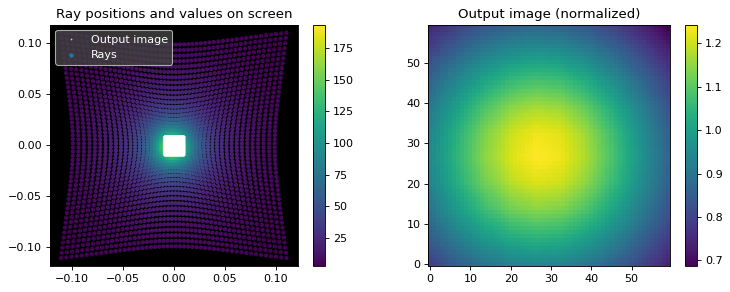

Loss: 1.22e+03: 100%|██████████| 45/45 [00:01<00:00, 35.59it/s]



Predicted: d = 0.0077mm


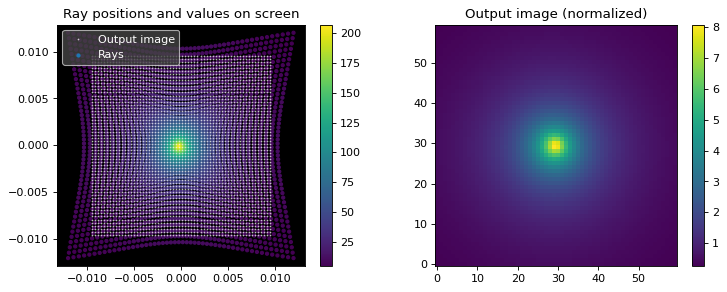

Ground truth: d = 0.0600


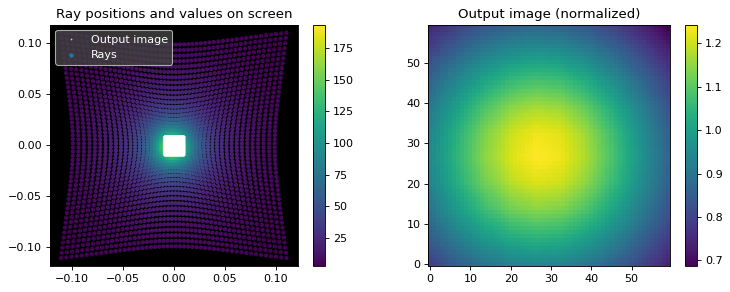

Ground truth: d = 0.0600mm. Screenpoint at 1.96µm


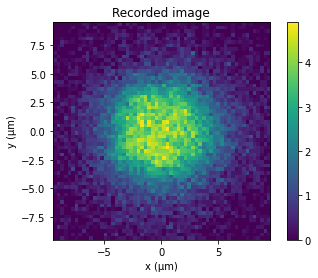

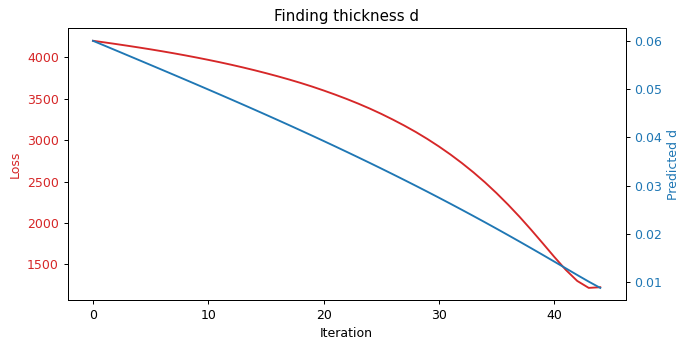

In [14]:
class RayLearner(nn.Module):
    def __init__(self, d, screenpoint):
        super(RayLearner, self).__init__()
        self.d = nn.Parameter(d, requires_grad=True)
        self.screenpoint = screenpoint
        
    def forward(self):
        d = self.d
        screenpoint = self.screenpoint
        n = 1.5213
        
        # Point source
        Nx = 50
        Ny = 50
        
        mult_opening = 2.5;
        p0x, p0y = torch.meshgrid(mult_opening*torch.linspace(-1.001,1.0,Nx, device=dev), mult_opening*torch.linspace(-1.0,1.0,Ny, device=dev))
        p0z = -torch.ones(Ny,Nx,device=dev)#*torch.linspace(1,1,Nx)
        p0 = torch.stack((p0x, p0y, p0z), 2)
        
        p1 = grid_vector3((0,0,0))
        s0 = unit(p1 - p0)
        
        # Propagate through coverslip
#         n_glass = self.n
        n_glass = n
        
        # Compute ray intersections with coverslip front ####
        coverslip_front = grid_vector3((0,0,-0.5))
        coverslip_norm = grid_vector3((0,0,-1))
        t = inner((coverslip_front - p0), (coverslip_norm)) / inner(s0, coverslip_norm)
        p2 = p0 + s0*t

        s2 = snellsvec(s0, coverslip_norm, n_in=1, n_out=n_glass)
        
        # Compute ray intersections with coverslip back ####
#         d = self.d
        coverslip_norm = grid_vector3((0,0,-1))
        coverslip_back = -d*coverslip_norm + coverslip_front
        t = inner((coverslip_back - p2), (coverslip_norm)) / inner(s2, coverslip_norm)
        p3 = p2 + s2*t

        s3 = snellsvec(s2, coverslip_norm, n_in=n_glass, n_out=1)
        
        # CCD plane
        screennorm  = grid_vector3((0,0,-1))

        # Compute ray intersections with screen ####
        t = inner((screenpoint - p3), (screennorm)) / inner(s3, screennorm)
        pscreen = p3 + s3*t

        ### Compute screen coordinates

        # Approximate ray density by computing cross product
        p1_xdiff = diff(s0, 0)
        p1_ydiff = diff(s0, 1)
        p1_areas = torch.abs(p1_xdiff.cross(p1_ydiff).norm(dim=2))

        pscreen_xdiff = diff(pscreen, 0)
        pscreen_ydiff = diff(pscreen, 1)
        pscreen_areas = torch.abs(pscreen_xdiff.cross(pscreen_ydiff).norm(dim=2))

        s_norm = s0.norm(dim=2)
        intensities = (1 / (s_norm*s_norm)) * (p1_areas / (pscreen_areas+0.00005))  ######
#         plt.imshow(pscreen_areas.detach().cpu()) ####################
#         plt.colorbar()
#         plt.show()

        # Interpolated resampling to image
        ### Assume screen normal=-z for now
        coords = pscreen[:,:,0:2]
        Nx_screen = frame_cropped_normalized.shape[0]
        Ny_screen = frame_cropped_normalized.shape[1]
        targets = torch.stack(torch.meshgrid(\
                torch.linspace(-xymax_mm, xymax_mm, Nx_screen, device=dev),\
                torch.linspace(-xymax_mm, xymax_mm, Ny_screen, device=dev)), 2)

        ##### Should be normalized. Quantitative intensity can give extra information
        interp_intensities_quant = interpolate2d(coords, intensities, targets)
        interp_intensities = interp_intensities_quant / torch.mean(interp_intensities_quant, (0,1))
        
            
#         plotrays((p0, p2, p3, pscreen))
        
        return interp_intensities, intensities, pscreen, targets, Nx, Ny, Nx_screen, Ny_screen


# Parameters
screenpoint = grid_vector3((0, 0, measure_offset_um*1e-3))  # Screenpoint position in mm
# screenpoint = grid_vector3((0, 0, 35*1e-3))  # Screenpoint position in mm

# Ground truth
d_gt = grid_scalar(0.4-2*0.17)

raylearner_gt = RayLearner(d_gt, screenpoint).to(dev)
interp_intensities, *stuff = raylearner_gt()

# Initial guess
d_pred = grid_scalar(0.4-2*0.17)

raylearner_train = RayLearner(d_pred, screenpoint).to(dev)
optimizer = torch.optim.Adam(raylearner_train.parameters(), lr=1.0e-3)
criterion = nn.MSELoss(reduction='sum')
interp_intensities_pred, *stuff_pred = raylearner_train()
print(f'Initial guess: d = {raylearner_train.d.detach().item():.4f}mm')
plotresult(interp_intensities_pred, stuff_pred)

# iterations=120
iterations=45
losses = torch.zeros(iterations)
dpreds = torch.zeros(iterations)
trange = tqdm(range(iterations), desc='Loss: -')

for t in trange:
    # Forward pass
    interp_intensities_pred, *stuff_pred = raylearner_train()
    
    # Compute and print loss
    loss = criterion(interp_intensities_pred, frame_cropped_normalized)
    loss_value = loss.detach().item()
    losses[t] = loss_value
    dpreds[t] = raylearner_train.d.detach().item()
    
#     if 1.05*losses[t-1] < loss_value:
#         print('Loss went up!')
#         plotresult(interp_intensities_pred, stuff_pred)
    
    trange.desc = f'Loss: {loss_value:<8.3g}'
    
    optimizer.zero_grad()
    
    loss.backward(retain_graph=True)
    optimizer.step()


print(f'\nPredicted: d = {raylearner_train.d.detach().item():.4f}mm')
plotresult(interp_intensities_pred, stuff_pred)

print(f'Ground truth: d = {raylearner_gt.d.detach().item():.4f}')
plotresult(interp_intensities, stuff)
print(f'Ground truth: d = {d_gt.cpu().item():.4f}mm. Screenpoint at {measure_offset_um.item():.2f}µm')
plt.imshow(frame_cropped_normalized.cpu(), extent=(colrange_um.min(), colrange_um.max(), rowrange_um.min(), rowrange_um.max()))
plt.title('Recorded image')
plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.colorbar()
plt.show()

fig, ax1 = plt.subplots(figsize=(8,4), dpi=90)
color1 = 'tab:red'
ax1.plot(losses, color=color1)
plt.title('Finding thickness d')
ax1.set_ylabel('Loss', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
plt.xlabel('Iteration')

color2 = 'tab:blue'
ax2 = ax1.twinx()
ax2.plot(dpreds, color=color2)
ax2.set_ylabel('Predicted d', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
plt.show()


In [ ]:
class CorrectionPattern(nn.Module):
    def __init__(self):
        super(CorrectionPattern, self).__init__()
        
    def forward(self, d, p0):
        n = 1.5213   # Coverslip glass refractive index
#         f = 1.65  # Objective effective focal distance in mm
        f = 1
        NA = 0.8  # Objective Numerical Aperture
        
        # Point source
        Nx = 40
        Ny = 40

        p1x, p1y = torch.meshgrid(torch.linspace(-2.5001,2.5,Nx, device=dev), torch.linspace(-2.5,2.5,Ny, device=dev))
        p1z = torch.ones(Ny,Nx,device=dev)
        p1 = torch.stack((p1x, p1y+0.1, p1z), 2)
        
        p0 = torch.stack((p1x, p1y, torch.zeros(Ny, Nx, device=dev)), 2) #####
        
        s0 = unit(p1 - p0)
        
        # Propagate through coverslip
#         n_glass = self.n
        n_glass = n
        
        # Compute ray interaction with coverslip front ####
        coverslip_front = grid_vector3((0,0,0.5))
        coverslip_fnorm = grid_vector3((0,0,-1))
        p2 = ray_plane_intersect(p0, s0, coverslip_front, coverslip_fnorm)
        s2 = snellsvec(s0, coverslip_fnorm, n_in=1, n_out=n_glass)
        
        # Compute ray interaction with coverslip back ####
        coverslip_bnorm = grid_vector3((0,0,-1))
        coverslip_back = -d*coverslip_bnorm + coverslip_front
        p3 = ray_plane_intersect(p2, s2, coverslip_back, coverslip_bnorm)
        s3 = snellsvec(s2, coverslip_bnorm, n_in=n_glass, n_out=1)
        
        # Compute ray interaction with thin lens
        lens_dir = grid_vector3((0,0,-1))
        lens_pos = -f*lens_dir
        p4, s4, Delta = thinlens(p3, s3, lens_pos, lens_dir, f)
        
        # CCD plane
        screennorm  = grid_vector3((0,0,-1))
        screenpoint = -2*f*screennorm
        pscreen = ray_plane_intersect(p4, s4, screenpoint, screennorm)
        

        ### Compute screen coordinates

        # Approximate ray density by computing cross product
        p1_xdiff = diff(s0, 0)
        p1_ydiff = diff(s0, 1)
        p1_areas = torch.abs(p1_xdiff.cross(p1_ydiff).norm(dim=2))

        pscreen_xdiff = diff(pscreen, 0)
        pscreen_ydiff = diff(pscreen, 1)
        pscreen_areas = torch.abs(pscreen_xdiff.cross(pscreen_ydiff).norm(dim=2))

        s_norm = s0.norm(dim=2)
        intensities = (1 / (s_norm*s_norm)) * (p1_areas / (pscreen_areas+0.005))  ######

        # Interpolated resampling to image
        ### Assume screen normal=-z for now
        coords = pscreen[:,:,0:2]
        Nx_screen = 50
        Ny_screen = 50
        
        print(f'f:{f}')
        D2 = half_diameter(f, NA, 1)
        print(f'half diameter: {D2}')
        targets = torch.stack(torch.meshgrid(\
                torch.linspace(-D2,D2,Nx_screen,device=dev),\
                torch.linspace(-D2,D2,Ny_screen,device=dev)), 2)

        ##### Should be normalized. Quantitative intensity can give extra information
        interp_intensities_quant = interpolate2d(coords, intensities, targets)
        interp_intensities = interp_intensities_quant / torch.mean(interp_intensities_quant, (0,1))
        
        
        # Compute total pathlength  #### reformat this later when using ray objects
        points = (p0, p2, p3, p4, pscreen)
        ns     = (1, n,  1,  1)
        total_pathlength = pathlength(points, ns, Delta)
        
        ######
#         plt.imshow(Delta.cpu())
#         plt.title('Delta')
#         plt.colorbar()
#         plt.show()
        
        print('\ntest')
        
        testlength = pathlength((p0, p2, p3, p4, pscreen), (1,1,1,1), Delta)
        
        plt.imshow(testlength.cpu())
        plt.title('test length')
        plt.colorbar()
        plt.show()
        ######
        
        interp_pathlength = interpolate2d(coords, total_pathlength, targets)  #### assume for now all points are on a flat z plane
        
        # Plot rays
        p0bc, p2bc = torch.broadcast_tensors(p0, p2)
        plotrays((p0bc, p2, p3, p4, pscreen))
        
        return interp_pathlength, total_pathlength, interp_intensities, intensities, pscreen, targets, Nx, Ny, Nx_screen, Ny_screen

d = 0.17*0

correction = CorrectionPattern().to(dev)
interp_pathlength, total_pathlength, interp_intensities, intensities, *stuff = correction(d, grid_vector3((0*5e-3,0*2e-3,-d*1.5)))

print('\nIntensities')
plotresult(interp_intensities, (intensities, *stuff))

print('\nPath lengths')
plotresult(interp_pathlength, (total_pathlength, *stuff))    ######## fix arguments (T_T)

#### Take defocus into account

In [ ]:
pscreen_np = stuff[0].cpu().numpy()
total_pathlength_np = total_pathlength.squeeze().cpu().numpy()

total_pathlength_np.shape
pscreen_np[:,:,0].shape

newsize = 400
f = interp.interp2d(pscreen_np[:,:,0], pscreen_np[:,:,1], total_pathlength_np, kind='linear')
# f = interp.SmoothBivariateSpline(pscreen_np[:,:,0], pscreen_np[:,:,1], total_pathlength_np, kx=3, ky=3)

x = np.linspace(pscreen_np[0,0,0], pscreen_np[-1,-1,0], newsize)
y = np.linspace(pscreen_np[0,0,1], pscreen_np[-1,-1,1], newsize)
pathlength_np = f(x, y)

wavelength = 630e-6
phase_np = 2*math.pi * np.mod(pathlength_np, wavelength)/wavelength
# phase_np = 2*math.pi * pathlength_np/wavelength

print('\nPhase')
fig = plt.figure(figsize=(10,7))
fig.dpi = 80
plt.imshow(phase_np)
plt.colorbar()
plt.show()